This notebook is for testing methods for performing a tidal analysis on the RIOPS currents.

Data
* RIOPS forecasts June 1-30, 2022, hourly frequency, surface currents (30 days)
* First 6 hours of every forecast is used (best esitmate)

Unfortuantely, we don't have hourly data for a continuous time series at the surface. I'm worried that compiling the best esitmate from the forecasts will results in an inaccruate tidal analysis

# Notes on tidal analysis
https://tidesandcurrents.noaa.gov/publications/Tidal_Analysis_and_Predictions.pdf
* Only consituents with a synodic period less than 30 days are used analyzed (see above reference, Table 3.2)
These include
* M2, M4, M6, M8, K1, S6, O1, OO1, 2MK3, MK3, 2Q1, S2, 2SM2, MS4, S4, M1, M3, N2, Q1, J1, MN4

In [1]:
import pytides.constituent as constituent
my_consts = [
    constituent._M2, constituent._S2, constituent._N2, constituent._K1, constituent._M4, constituent._O1, 
    constituent._M6, constituent._MK3, constituent._S4, constituent._MN4, constituent._S6, constituent._OO1, 
    constituent._M1, constituent._J1, constituent._Q1, constituent._2Q1, constituent._2SM2, constituent._M3,
    constituent._2MK3, constituent._M8, constituent._MS4
]

In [2]:
import glob
import os
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pytides.tide import Tide

In [3]:
plt.style.use('seaborn-talk')

In [4]:
data='/home/soontiensn/data/DenisLefaivre/riops/data/'

In [5]:
ufiles=glob.glob(os.path.join(data, '*VOZOCRTX*.nc'))
ufiles.sort()
du=xr.open_mfdataset(ufiles)

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [6]:
du

<xarray.Dataset>
Dimensions:              (time: 720, xc: 1770, yc: 1610)
Coordinates:
  * xc                   (xc) float32 0.0 5000.0 10000.0 ... 8840000.0 8845000.0
  * yc                   (yc) float32 0.0 5000.0 10000.0 ... 8040000.0 8045000.0
    latitude             (yc, xc) float32 30.56034 30.58307 ... 41.46735
    longitude            (yc, xc) float32 221.2824 221.31534 ... 20.87038
  * time                 (time) datetime64[ns] 2022-06-01 ... 2022-06-30T23:00:00
Data variables:
    polar_stereographic  (time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    vozocrtx             (time, yc, xc) float32 dask.array<shape=(720, 1610, 1770), chunksize=(1, 1610, 1770)>
Attributes:
    Conventions:      CF-1.6
    title:            Instantaneous sea ice and ocean forecast fields
    institution:      The Canadian Centre for Meteorological and Environmenta...
    source:           Regional Ice Ocean Prediction System: version 2.2.0
    product_version:  RIOPS_2.2.0_F
    creation_

In [7]:

lons = du.longitude
lats = du.latitude

In [8]:
stations = {'Gulf': [1350,350],
            'NL': [1500,450],
            'Pacific': [400,400],
            'Arctic': [1100, 750]}

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


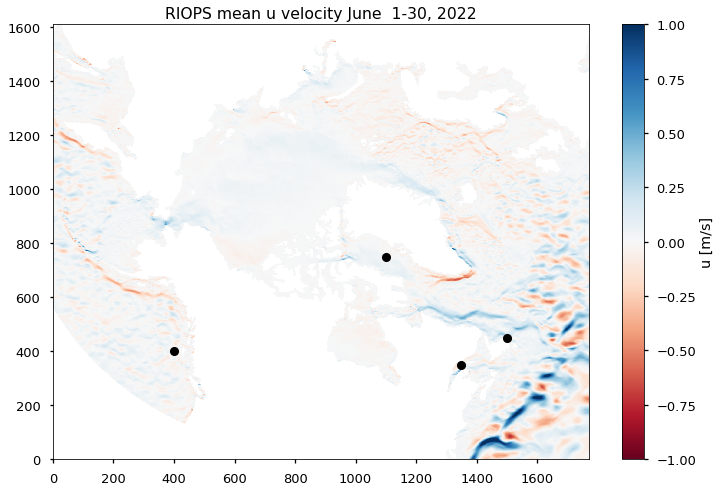

In [9]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
umean = du.vozocrtx.mean(dim='time').values
mesh=ax.pcolormesh(umean,vmin=-1,vmax=1,cmap='RdBu')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('u [m/s]')
for name in stations:
    i,j=stations[name]
    ax.plot(i,j, 'ko')
ax.set_title('RIOPS mean u velocity June  1-30, 2022')
fig.savefig('RIOPS-meanU-June2022.png')

# Plan
* Tidal analysis on U
* Find residule currents
* Power spectrum of residuls - is there energy at 6 hours? 

In [25]:
def tidal_analysis(speeds, times,  print_const=True, constituents=my_consts):
    demeaned = speeds - speeds.mean()
    dates=pd.to_datetime(times)
    if constituents:
        tide = Tide.decompose(demeaned,dates, constituents=my_consts)
    else:
        tide = Tide.decompose(demeaned,dates,)
    
    #print constituents
    constituent = [c.name for c in tide.model['constituent']]
    df = pd.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)
    if print_const:
        display(df.sort_values('amplitude', ascending=False))

    
    #tidal prediction
    hours = np.cumsum(np.r_[0, [t.total_seconds() / 3600.0
                            for t in np.diff(dates.to_pydatetime())]])
    times = Tide._times(dates[0], hours)
    prediction = pd.Series(tide.at(times) + speeds.mean(), index=dates)
    
    return tide, prediction

In [23]:
def analyze_station(name):
    i,j = stations[name]
    uts = du.isel(xc=i,yc=j).vozocrtx.values
    lon = du.isel(xc=i,yc=j).longitude.values
    lon = lon -360 if lon > 180 else lon
    lat = du.isel(xc=i,yc=j).latitude.values
    times = du.time.values
    tide, prediction = tidal_analysis(uts, times, constituents=my_consts)
    
    # plot current + predcition
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    ax.plot(times, uts, color='C0', label='u')
    ax.plot(times, prediction.values, color='k', label='tidal prediction')
    ax.set_ylim([-.7,.7])
    ax.set_xlim(datetime(2022,6,1), datetime(2022,7,1))
    ax.legend()
    ax.grid()
    ax.set_title(f'{name}: [{lon:.2f}, {lat:.2f}]')
    ax.set_ylabel('[m/s]')
    fig.savefig(f'{name}-prediction-June2022.png', bbox_inches='tight')
    
    # plot residual + power spectrum
    residual=uts-prediction
    fig,axs=plt.subplots(2,1,figsize=(15,12))
    ax=axs[0]
    ax.plot(times, residual)
    ax.set_xlim(datetime(2022,6,1), datetime(2022,7,1))
    ax.grid()
    ax.set_title(f'{name} residual current')
    ax.set_ylabel('[m/s]')
    
    # power spectrum
    ax=axs[1]
    freqs = np.fft.fftfreq(residual.values.size, 1/24)
    idx = np.argsort(freqs)
    psd = np.abs(np.fft.fft(residual.values))**2
    ax.plot(freqs[idx], psd[idx], label='__nolegend__')
    m=psd.max()
    # K1
    ax.plot(24*np.array([1/23.93, 1/23.93]), [0,m], 'r--', lw=3,label='K1',zorder=0)
    # M2
    ax.plot(24*np.array([1/12.42, 1/12.42]), [0,m], 'b--', lw=3, label='M2',zorder=0)
    # 6 hours
    ax.plot(24*np.array([1/(6.), 1/(6.)]), [0,m], 'g--', lw=3, label='6 hours',zorder=0)
    ax.legend()
    ax.set_xlim([0,freqs.max()])
    ax.grid()
    ax.set_xlabel('Frequency (cycles/day)')
    ax.set_ylabel('Power spectrum of residual')
    fig.savefig(f'{name}-residual-June2022.png', bbox_inches='tight')

In [26]:
analyze_station('Gulf')

amplitude       phase
M2    2.453090e-01  358.049655
N2    7.841793e-02  328.092347
M1    5.355676e-02  183.185813
S2    5.219314e-02   25.771133
O1    4.345385e-02   19.372813
K1    3.548300e-02   32.729094
Q1    1.682430e-02  286.437899
2Q1   1.653925e-02  239.773708
J1    1.282336e-02   26.370296
M4    9.211790e-03  223.378307
OO1   8.346781e-03   69.652804
S4    5.687012e-03  109.562512
MK3   4.565448e-03  239.420911
2SM2  4.472860e-03  159.310327
MN4   3.605598e-03  151.398589
M6    3.381389e-03   19.435129
S6    1.531262e-03  117.609668
2MK3  1.274862e-03  141.197787
M8    1.223512e-03  288.457087
MS4   1.149906e-03  277.357424
M3    8.291342e-05  244.907675
Z0    2.251731e-08    0.000000

In [27]:
analyze_station('NL')

amplitude       phase
K1    2.555605e-02  259.649931
M1    1.599178e-02   80.653951
M2    1.543811e-02  323.604911
O1    1.174562e-02  309.987531
S2    8.291193e-03   47.460630
Q1    6.854741e-03  180.218596
J1    6.852354e-03  312.733094
2Q1   5.670673e-03   85.559664
N2    3.569029e-03   34.911658
OO1   3.008847e-03   12.353575
S4    2.394686e-03  149.189847
M4    2.370007e-03  133.297136
MS4   1.561198e-03  259.837975
MN4   1.525418e-03   48.479678
2MK3  1.105579e-03  310.158343
S6    8.644435e-04  124.954737
M3    5.576407e-04  139.057148
MK3   4.808653e-04  219.639842
2SM2  3.124545e-04  133.201961
M6    1.792721e-04  263.544791
M8    1.535665e-05  303.839706
Z0    1.324548e-09    0.000000

amplitude       phase
M2    5.525679e-02  219.453476
K1    2.502093e-02  343.864072
S2    1.744567e-02  244.017597
N2    1.544258e-02  204.440587
O1    6.047910e-03  348.760706
J1    4.138349e-03   19.008652
M1    3.303153e-03  115.334213
2Q1   2.594210e-03  103.449747
2SM2  2.312049e-03  334.104011
Q1    2.007189e-03  205.843722
2MK3  1.087303e-03  311.546734
OO1   8.867662e-04  107.366708
M4    8.469700e-04  341.618237
M3    7.741880e-04  231.694453
MK3   7.474259e-04  295.833841
S4    7.086721e-04  297.268454
M6    3.654758e-04  180.414124
MS4   3.035437e-04  263.968653
MN4   2.751535e-04  164.849959
S6    1.999010e-04  313.503763
M8    1.990484e-04   14.758382
Z0    1.655685e-09  180.000000

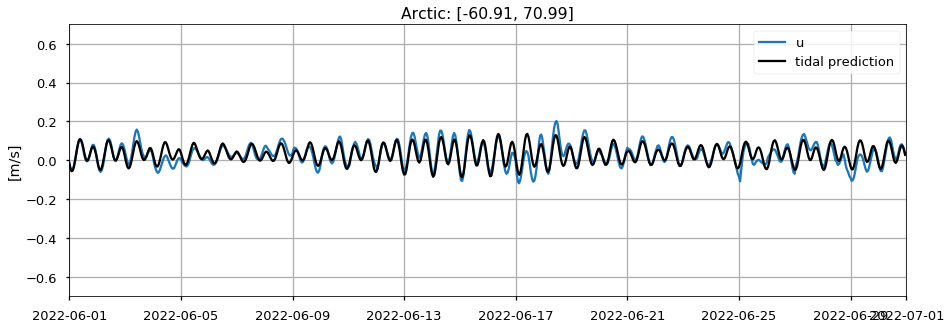

In [28]:
analyze_station('Arctic')

amplitude       phase
M2     0.041869  128.411505
N2     0.018666  148.303358
K1     0.011320  127.459476
M1     0.007912  237.426058
OO1    0.007540  171.582160
Q1     0.006941  357.752057
S2     0.005974  143.017552
J1     0.005210   76.823197
O1     0.004573  125.716854
2Q1    0.003940  269.666424
M4     0.002507  277.442975
M3     0.002410  213.282539
MK3    0.002056    9.233274
2SM2   0.001250   38.685723
2MK3   0.001069   50.223439
MS4    0.000757  322.744234
MN4    0.000703  199.591688
M8     0.000672  240.071357
M6     0.000516  338.912360
S6     0.000488  104.097091
S4     0.000481  247.456642
Z0     0.000000    0.000000

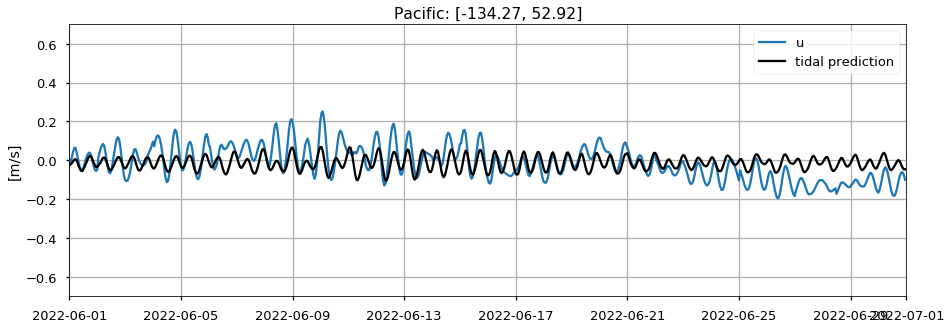

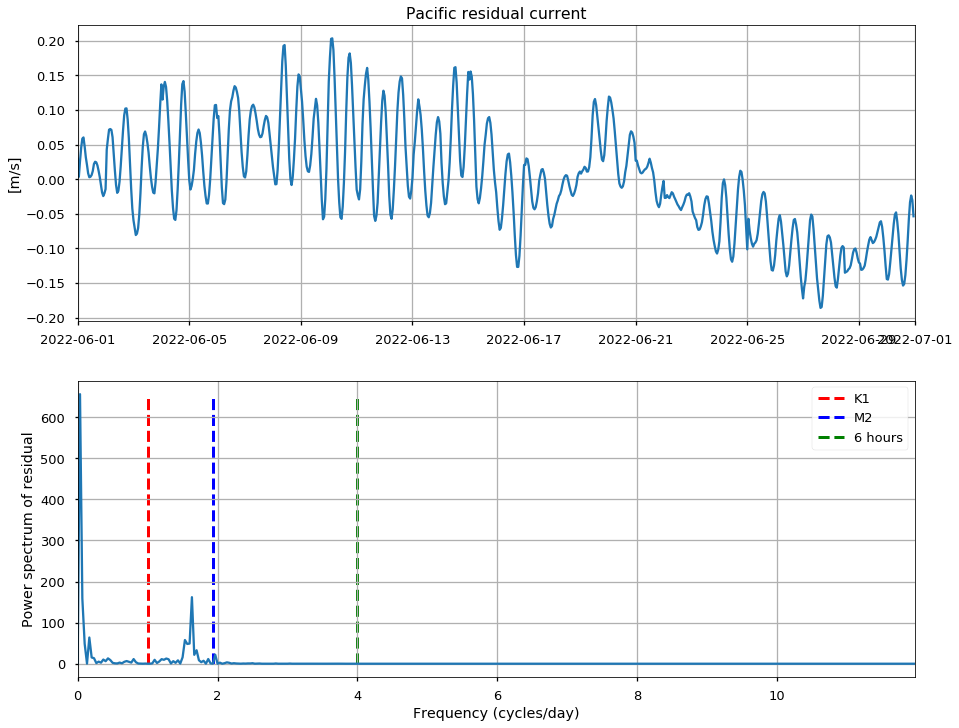

In [29]:
analyze_station('Pacific')